# Input Library

In [1]:
import os          # untuk navigasi dan manipulasi file/direktori
import shutil      # untuk memindahkan/menyalin file
import pathlib     # untuk manajemen path yang lebih modern
import pandas as pd    # jika kamu memproses data (misalnya .csv, .xlsx)
from pathlib import Path
import datetime
import re
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import preprocessing_utils as pu

In [1]:
# RUN_MODE = "prod"  # atau "debug"

# if RUN_MODE == "debug":
#     print("Debug cell")

# Input Direktori Folder

In [3]:
# # Direktori Downloads
# downloads_dir = Path(r"C:\Users\ASUS\Downloads")
# downloads_info = []

# # Direktori Documents
# documents_dir = Path(r"C:\Users\ASUS\OneDrive\Documents")
# documents_info = []

# Output Folder

In [4]:
# # Folder output utama
# output_dir = Path("Output")
# output_dir.mkdir(exist_ok=True)

# Ekstraksi Dataframe

In [5]:
# # List untuk menyimpan info file
# file_info = []

In [6]:
def extract_file_info(file_path, source_label):
    stat = file_path.stat()
    size_kb = stat.st_size / 1024
    size_gb = stat.st_size / (1024 ** 3)
    
    # Buat path yang lebih sederhana: hanya relatif ke root_dir
    try:
        simple_path = file_path.relative_to(file_path.anchor)
    except ValueError:
        simple_path = file_path.name  # fallback jika error

    return {
        "FileName": file_path.stem,
        "FileExt": file_path.suffix.lower(),
        "DateModified": datetime.datetime.fromtimestamp(stat.st_mtime),
        "Size_KB": round(size_kb, 2),
        "Size_GB": round(size_gb, 4),
        "Source": source_label,
        "Path": str(file_path),
        "SimplePath": str(simple_path),
        "ParentPath": str(file_path.parent)
    }

## Ekstrak Metadata dari Folder Downloads

In [7]:
# # Loop semua file dalam Downloads (rekursif)
# for file in downloads_dir.rglob("*"):
#     if file.is_file():
#         downloads_info.append(extract_file_info(file, "Downloads"))

In [8]:
# # Konversi ke DataFrame
# df_downloads = pd.DataFrame(downloads_info)
# df_downloads.sort_values(by="DateModified", ascending=False, inplace=True)

In [9]:
# df_downloads

In [10]:
# # Simpan ke CSV
# df_downloads.to_csv(output_dir / "folder-downloads-metadata.csv", index=False)
# print("Metadata dari Downloads berhasil disimpan ke 'Output/folder-downloads-metadata.csv'")

## Ekstrak Metadata dari Folder Documents

In [11]:
# # Loop semua file dalam Documents (rekursif)
# for file in documents_dir.rglob("*"):
#     if file.is_file():
#         documents_info.append(extract_file_info(file, "Documents"))

In [12]:
# # Konversi ke DataFrame
# df_documents = pd.DataFrame(documents_info)

In [13]:
# df_documents

In [14]:
# # Simpan ke CSV
# df_documents.to_csv(output_dir / "folder-documents-metadata.csv", index=False)
# print("Metadata dari Documents berhasil disimpan ke 'Output/folder-documents-metadata.csv'")

# Input Dataframe dari CSV

In [15]:
# df_documents = pd.read_csv("folder-documents-metadata.csv")

In [16]:
# df_documents.columns

In [2]:
df_downloads = pd.read_csv("folder-downloads-metadata.csv")

In [3]:
df_downloads.columns

Index(['FileName', 'FileExt', 'DateModified', 'Size_KB', 'Size_GB', 'Source',
       'Path', 'SimplePath', 'ParentPath'],
      dtype='object')

# Pre-Processing Data Document Folder

## Pre-Processing FileName

Tujuan:
1. Menghapus karakter asing/simbol tidak penting
2. Menghapus spasi berlebih
3. Normalisasi huruf (lowercase/titlecase)
4. (Opsional) Tambah kolom baru seperti versi bersihnya (FileNameClean)

In [19]:
# Salin dulu biar tidak merusak kolom asli
df_documents['FileNameClean'] = df_documents['FileName']

NameError: name 'df_documents' is not defined

In [ ]:
# Hilangkan karakter tidak penting (misal: _ - () [])
df_documents['FileNameClean'] = df_documents['FileNameClean'].str.replace(r'[\[\]\(\)\{\}_\-]', ' ', regex=True)

In [ ]:
# Hilangkan simbol selain huruf/angka/spasi
df_documents['FileNameClean'] = df_documents['FileNameClean'].str.replace(r'[^\w\s]', '', regex=True)

In [ ]:
# Ubah multiple space jadi satu spasi
df_documents['FileNameClean'] = df_documents['FileNameClean'].str.replace(r'\s+', ' ', regex=True)

In [ ]:
# Trim spasi di awal dan akhir
df_documents['FileNameClean'] = df_documents['FileNameClean'].str.strip()

In [ ]:
# Ubah menjadi huruf kecil atau kapitalisasi
df_documents['FileNameClean'] = df_documents['FileNameClean'].str.title()

In [ ]:
df_documents['FileNameClean'].sample(5)

86                                       Ipc
458            Cover Letter For Kideco Fajri
237                                    Tcc64
644      Draft Interview Fajri For Mt At Ymt
588    Ijazah Fajri Compressed Kurang 500 Kb
Name: FileNameClean, dtype: object

### Modular Function for FileName

In [ ]:
# import pandas as pd

# def clean_filename_column(df, source_col='FileName', new_col='FileNameClean', to_lower=False, to_title=True):
#     """
#     Membersihkan nama file dari karakter asing, simbol, dan spasi berlebih.
#     """
#     series = df[source_col].astype(str)

#     # Bersihkan karakter asing: kurung, tanda baca, simbol
#     series = series.str.replace(r'[\[\]\(\)\{\}_\-]', ' ', regex=True)
#     series = series.str.replace(r'[^\w\s]', '', regex=True)
#     series = series.str.replace(r'\s+', ' ', regex=True)
#     series = series.str.strip()

#     # Format huruf
#     if to_lower:
#         series = series.str.lower()
#     elif to_title:
#         series = series.str.title()

#     df[new_col] = series
#     return df

In [ ]:
df_documents['FileNameClean'].isna().sum()

0

## Pre-Processing FileExt

Tujuan:
1. Bersihkan dan seragamkan ekstensi (hilangkan titik, jadikan lowercase).
2. Klasifikasikan ekstensi ke dalam kelompok file (dokumen, gambar, audio, dll).
3. (Opsional) Hitung frekuensi tiap jenis file.

### Modular Function for FileExt

In [ ]:
# import pandas as pd
# import matplotlib.pyplot as plt
# from matplotlib.patches import Rectangle

# def classify_and_plot_filetypes(df, ext_column='FileExt'):
#     # 1. Gabungan peta ekstensi
#     extension_map = {
#         'doc': 'document', 'docx': 'document', 'pdf': 'document', 'txt': 'document', 'pptx': 'document', 'guides': 'document',
#         'xls': 'spreadsheet', 'xlsx': 'spreadsheet', 'csv': 'spreadsheet',
#         'jpg': 'image', 'jpeg': 'image', 'png': 'image', 'gif': 'image', 'bmp': 'image',
#         'mp4': 'video', 'mkv': 'video', 'mov': 'video', 'avi': 'video',
#         'mp3': 'audio', 'wav': 'audio', 'm4a': 'audio', 'pima': 'audio', 'pimx': 'audio', 'sig': 'audio', 'essentialsound': 'audio', 'aup3': 'audio',
#         'zip': 'archive', 'rar': 'archive', '7z': 'archive',
#         'py': 'code', 'ipynb': 'code', 'js': 'code', 'html': 'code', 'css': 'code', 'json': 'code', 'xml': 'code',
#         'exe': 'system', 'dll': 'system',
#         'ini': 'config', 'conf': 'config',
#         'log': 'log',
#         'woff': 'web',
#         'prproj': 'project', 'prmdc2': 'project', 'olp': 'project'
#     }

#     # 2. Normalisasi ekstensi
#     df[ext_column] = df[ext_column].str.lower().str.replace('.', '', regex=False)

#     # 3. Klasifikasi
#     df['FileType'] = df[ext_column].map(extension_map).fillna('other')

#     # 4. Hitung frekuensi & persentase
#     filetype_counts = df['FileType'].value_counts()
#     total = filetype_counts.sum()
#     percentages = (filetype_counts / total * 100).round(1)
    
#     colors = list(plt.cm.tab20.colors[:len(filetype_counts)])
#     df_percent = pd.DataFrame({
#         'Color': colors,
#         'FileType': filetype_counts.index,
#         'Count': filetype_counts.values,
#         'Percentage (%)': percentages.values
#     })

#     # 5. Visualisasi: Pie chart
#     fig, ax = plt.subplots(figsize=(10, 6))
#     wedges, _ = ax.pie(
#         filetype_counts,
#         labels=None,
#         startangle=140,
#         colors=colors,
#         wedgeprops=dict(width=0.4)
#     )
#     ax.set_title('FileType Distribution')

#     # 6. Tabel warna samping
#     table_ax = fig.add_axes([0.7, 0.15, 0.28, 0.7])
#     table_ax.axis('off')

#     for i, (color, filetype, count, pct) in enumerate(zip(df_percent['Color'], 
#                                                            df_percent['FileType'], 
#                                                            df_percent['Count'], 
#                                                            df_percent['Percentage (%)'])):
#         table_ax.add_patch(Rectangle((0, i), 0.2, 1, color=color, transform=table_ax.transData))
#         table_ax.text(0.25, i + 0.5, filetype, va='center')
#         table_ax.text(1.2, i + 0.5, str(count), va='center')
#         table_ax.text(2.0, i + 0.5, f"{pct}%", va='center')

#     table_ax.set_xlim(0, 2.5)
#     table_ax.set_ylim(0, len(df_percent))
#     table_ax.set_title("FileType Details", loc='left', fontsize=10, weight='bold')

#     plt.tight_layout()
#     plt.show()

#     return df, df_percent  # Optional: return untuk pemakaian selanjutnya

In [ ]:
df_documents['FileExt'] = df_documents['FileExt'].str.lower().str.replace('.', '', regex=False)

In [ ]:
extension_map = {
    'doc': 'document', 'docx': 'document', 'pdf': 'document', 'txt': 'document',
    'xls': 'spreadsheet', 'xlsx': 'spreadsheet', 'csv': 'spreadsheet',
    'jpg': 'image', 'jpeg': 'image', 'png': 'image', 'gif': 'image', 'bmp': 'image',
    'mp4': 'video', 'mkv': 'video', 'mov': 'video', 'avi': 'video',
    'mp3': 'audio', 'wav': 'audio',
    'zip': 'archive', 'rar': 'archive', '7z': 'archive',
    'py': 'code', 'ipynb': 'code', 'js': 'code', 'html': 'code', 'css': 'code'
}

In [ ]:
df_documents['FileType'] = df_documents['FileExt'].map(extension_map).fillna('other')

In [ ]:
df_documents['FileType'].value_counts()

FileType
document       271
other          257
archive         91
image           82
code             4
spreadsheet      2
video            1
Name: count, dtype: int64

In [ ]:
df_documents[df_documents['FileType'] == 'other']['FileExt'].value_counts()

FileExt
pima              52
pimx              52
sig               52
essentialsound    44
json              21
xml                6
prproj             5
m4a                4
exe                3
pptx               2
ini                2
dll                2
woff               1
guides             1
prmdc2             1
olp                1
aup3               1
log                1
conf               1
Name: count, dtype: int64

Penjelasan Ekstensi "Other":

| Ekstensi         | Keterangan                                              | Disarankan `FileType`                   |
| ---------------- | ------------------------------------------------------- | --------------------------------------- |
| `pima`, `pimx`   | Adobe Premiere audio/sequence markers                   | `audio` or `project` *(pilih satu)*     |
| `sig`            | Signature file (mungkin dari Adobe Audio)               | `audio` / `config` (tergantung konteks) |
| `essentialsound` | Adobe Essential Sound Presets                           | `audio` / `project`                     |
| `json`, `xml`    | Structured config/data                                  | `code` or `config`                      |
| `prproj`         | Adobe Premiere Pro project file                         | `video` or `project`                    |
| `m4a`            | Audio                                                   | `audio`                                 |
| `exe`, `dll`     | Program executable & library                            | `binary` or `system`                    |
| `pptx`           | PowerPoint                                              | `document`                              |
| `ini`, `conf`    | Configuration files                                     | `config`                                |
| `woff`           | Web font                                                | `web`                                   |
| `guides`         | Mungkin internal guide (butuh pengecekan)               | `document` or `other`                   |
| `prmdc2`, `olp`  | Tidak umum, kemungkinan file preset atau internal Adobe | `project` or `other`                    |
| `aup3`           | Audacity project file                                   | `audio` or `project`                    |
| `log`            | Log file                                                | `log` or `config`                       |

In [ ]:
additional_map = {
    'pima': 'audio',
    'pimx': 'audio',
    'sig': 'audio',
    'essentialsound': 'audio',
    'json': 'code',
    'xml': 'code',
    'prproj': 'project',
    'm4a': 'audio',
    'exe': 'system',
    'dll': 'system',
    'pptx': 'document',
    'ini': 'config',
    'conf': 'config',
    'log': 'log',
    'woff': 'web',
    'aup3': 'audio',
    'guides': 'document',
    'prmdc2': 'project',
    'olp': 'project'
}

df_documents['FileType'] = df_documents.apply(
    lambda row: additional_map.get(row['FileExt'], row['FileType']),
    axis=1
)

In [ ]:
df_documents['FileType'].value_counts()

FileType
document       274
audio          205
archive         91
image           82
code            31
project          7
system           5
other            5
config           3
spreadsheet      2
web              1
log              1
video            1
Name: count, dtype: int64

In [ ]:
# Ambil data frekuensi FileType
filetype_counts = df_documents['FileType'].value_counts()
total = filetype_counts.sum()
percentages = (filetype_counts / total * 100).round(1)

In [ ]:
colors = list(plt.cm.tab20.colors[:len(filetype_counts)])
df_percent = pd.DataFrame({
    'Color': colors,
    'FileType': filetype_counts.index,
    'Count': filetype_counts.values,
    'Percentage (%)': percentages.values
})

C:\Users\ASUS\AppData\Local\Temp\ipykernel_16236\1933764353.py:34: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


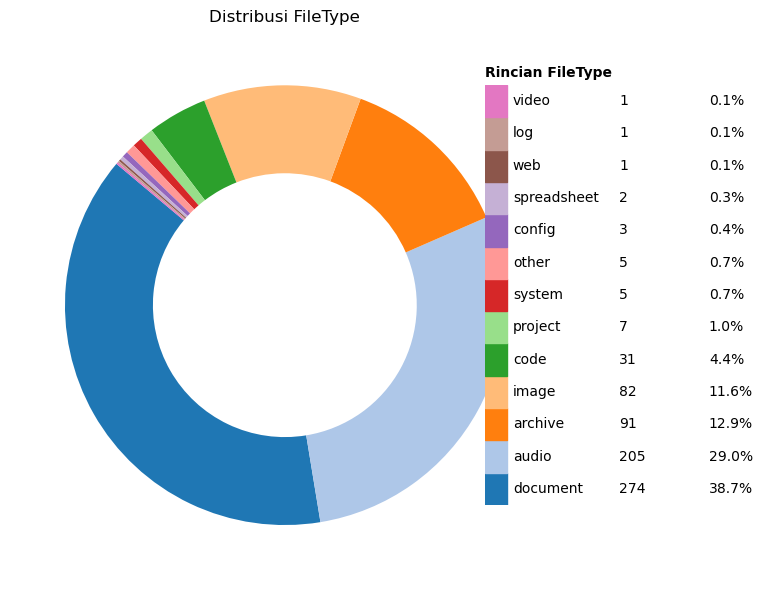

In [ ]:
# Pie chart (tanpa label)
fig, ax = plt.subplots(figsize=(10, 6))
wedges, _ = ax.pie(
    filetype_counts,
    labels=None,
    startangle=140,
    colors=colors,
    wedgeprops=dict(width=0.4)
)
ax.set_title('Distribusi FileType')

# Tabel dengan warna di samping
table_ax = fig.add_axes([0.7, 0.15, 0.28, 0.7])  # [left, bottom, width, height]
table_ax.axis('off')

# Buat isi tabel (dengan warna dalam bentuk patch rectangle)
from matplotlib.patches import Rectangle

# Tambahkan baris ke tabel satu per satu
for i, (color, filetype, count, pct) in enumerate(zip(df_percent['Color'], 
                                                       df_percent['FileType'], 
                                                       df_percent['Count'], 
                                                       df_percent['Percentage (%)'])):
    table_ax.add_patch(Rectangle((0, i), 0.2, 1, color=color, transform=table_ax.transData))
    table_ax.text(0.25, i + 0.5, filetype, va='center')
    table_ax.text(1.2, i + 0.5, str(count), va='center')
    table_ax.text(2.0, i + 0.5, f"{pct}%", va='center')

# Atur tampilan tabel agar rapih
table_ax.set_xlim(0, 2.5)
table_ax.set_ylim(0, len(df_percent))
table_ax.set_title("Rincian FileType", loc='left', fontsize=10, weight='bold')

plt.tight_layout()
plt.show()

In [ ]:
df_documents['FileType'].isna().sum()

0

## Pre-Processing DateModified

Tujuan:
Menyiapkan data waktu modifikasi file agar bisa dianalisis atau divisualisasikan secara akurat dan efisien

In [ ]:
df_documents['DateModified'] = pd.to_datetime(df_documents['DateModified'], errors='coerce')

In [ ]:
df_documents['DateModified'].sample(5)

407   2025-04-01 06:34:22.923520
693   2023-02-26 19:47:40.000000
50    2022-05-20 05:21:46.000000
414   2025-04-01 06:34:22.959605
10    2023-04-14 15:10:50.000000
Name: DateModified, dtype: datetime64[ns]

In [ ]:
df_documents['DateModified'].isna().sum()

0

In [ ]:
df_documents['year'] = df_documents['DateModified'].dt.year

In [ ]:
df_documents['month'] = df_documents['DateModified'].dt.month

In [ ]:
df_documents.sort_values('DateModified')  # urutkan dari yang paling lama

,FileName,FileExt,DateModified,Size_KB,Size_GB,Source,Path,SimplePath,ParentPath,FileNameClean,FileType,year,month
546,pas foto kemeja putih panjang,jpg,2006-04-02 04:07:14.000000,2360.84,0.0023,Documents,C:\Users\ASUS\OneDrive\Documents\FOLDER FAJRI\...,Users\ASUS\OneDrive\Documents\FOLDER FAJRI\cv ...,C:\Users\ASUS\OneDrive\Documents\FOLDER FAJRI\...,Pas Foto Kemeja Putih Panjang,image,2006,4
544,pas foto jas panjang atau full,jpg,2006-04-02 04:09:54.000000,2982.16,0.0028,Documents,C:\Users\ASUS\OneDrive\Documents\FOLDER FAJRI\...,Users\ASUS\OneDrive\Documents\FOLDER FAJRI\cv ...,C:\Users\ASUS\OneDrive\Documents\FOLDER FAJRI\...,Pas Foto Jas Panjang Atau Full,image,2006,4
255,AdobeColorCommonSetCMYK_1_0-mul,zip,2016-06-07 17:10:58.000000,8150.17,0.0078,Documents,C:\Users\ASUS\OneDrive\Documents\Adobe\Adobe I...,Users\ASUS\OneDrive\Documents\Adobe\Adobe InDe...,C:\Users\ASUS\OneDrive\Documents\Adobe\Adobe I...,Adobecolorcommonsetcmyk 1 0 Mul,archive,2016,6
262,AdobeColorNA_Recommended_1_0-mul,zip,2016-06-07 17:19:55.000000,1605.30,0.0015,Documents,C:\Users\ASUS\OneDrive\Documents\Adobe\Adobe I...,Users\ASUS\OneDrive\Documents\Adobe\Adobe InDe...,C:\Users\ASUS\OneDrive\Documents\Adobe\Adobe I...,Adobecolorna Recommended 1 0 Mul,archive,2016,6
258,AdobeColorEU_Recommended_1_0-mul,zip,2016-06-07 17:19:55.000000,1813.08,0.0017,Documents,C:\Users\ASUS\OneDrive\Documents\Adobe\Adobe I...,Users\ASUS\OneDrive\Documents\Adobe\Adobe InDe...,C:\Users\ASUS\OneDrive\Documents\Adobe\Adobe I...,Adobecoloreu Recommended 1 0 Mul,archive,2016,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...
644,DRAFT INTERVIEW Fajri for MT at YMT,pdf,2025-07-18 19:29:56.871769,79.03,0.0001,Documents,C:\Users\ASUS\OneDrive\Documents\FOLDER FAJRI\...,Users\ASUS\OneDrive\Documents\FOLDER FAJRI\Rec...,C:\Users\ASUS\OneDrive\Documents\FOLDER FAJRI\...,Draft Interview Fajri For Mt At Ymt,document,2025,7
645,DRAFT INTERVIEW Fajri for MT at YMT.pdf,docx,2025-07-18 19:31:30.166986,17.12,0.0000,Documents,C:\Users\ASUS\OneDrive\Documents\FOLDER FAJRI\...,Users\ASUS\OneDrive\Documents\FOLDER FAJRI\Rec...,C:\Users\ASUS\OneDrive\Documents\FOLDER FAJRI\...,Draft Interview Fajri For Mt At Ymtpdf,document,2025,7
653,interview format_template,docx,2025-07-18 19:36:22.660856,14.44,0.0000,Documents,C:\Users\ASUS\OneDrive\Documents\FOLDER FAJRI\...,Users\ASUS\OneDrive\Documents\FOLDER FAJRI\Rec...,C:\Users\ASUS\OneDrive\Documents\FOLDER FAJRI\...,Interview Format Template,document,2025,7
3,Cover Letter at Mott MacDonald,docx,2025-07-28 13:23:28.501258,14.82,0.0000,Documents,C:\Users\ASUS\OneDrive\Documents\Cover Letter ...,Users\ASUS\OneDrive\Documents\Cover Letter at ...,C:\Users\ASUS\OneDrive\Documents,Cover Letter At Mott Macdonald,document,2025,7


In [ ]:
df_documents['DateModified'] = pd.to_datetime(df_documents['DateModified'], errors='coerce', dayfirst=True)

### Modifikasi Delta Date Modified Sejak Hari ini (31 Juli 2025)

In [ ]:
now = pd.Timestamp(datetime.now())

In [ ]:
def label_usia_dokumen(date):
    if pd.isna(date):
        return 'tidak diketahui'
    delta = (now - date).days
    if delta <= 365:
        return 'baru'
    elif delta <= 5 * 365:
        return 'menengah'
    else:
        return 'lama'

In [ ]:
df_documents['UsiaDokumen'] = df_documents['DateModified'].apply(label_usia_dokumen)

In [ ]:
df_documents['UsiaDokumen'].value_counts()

UsiaDokumen
menengah    545
baru        132
lama         31
Name: count, dtype: int64

In [ ]:
df_documents['UsiaDokumen'].isna().sum()

0

## Pre-Processing Size

Tujuan:
1. Ubah Nilai Menjadi Tipe Numerik
2. Tangani Nilai Hilang atau Nol
3. (Opsional) Ubah ke Satuan Lain
4. (Opsional) Buat Kategori Ukuran File

In [ ]:
df_documents['Size_KB'] = pd.to_numeric(df_documents['Size_KB'], errors='coerce')

In [ ]:
df_documents['Size_KB'] = df_documents['Size_KB'].fillna(0)

In [ ]:
df_documents['Size_MB'] = df_documents['Size_KB'] / 1024  # Kilobyte ke Megabyte

In [ ]:
def size_category(size_kb):
    if size_kb < 100:
        return 'Kecil (<100KB)'
    elif size_kb < 1024:
        return 'Sedang (100KB–1MB)'
    else:
        return 'Besar (>1MB)'

In [ ]:
df_documents['SizeCategory'] = df_documents['Size_KB'].apply(size_category)

In [ ]:
df_documents['SizeCategory'].sample(5)

293    Sedang (100KB–1MB)
235        Kecil (<100KB)
329        Kecil (<100KB)
576    Sedang (100KB–1MB)
6          Kecil (<100KB)
Name: SizeCategory, dtype: object

In [ ]:
df_documents['SizeCategory'].isna().sum()

0

## Pre-Processing Source

Tujuan:
1. Membersihkan data teks (spasi berlebih, huruf besar/kecil).
2. Menstandarkan format sumber.
3. Menangani missing values / sumber tidak diketahui.
4. (Opsional) Menyederhanakan kategori / mapping.
5. (Opsional) Membuat kategori/klasifikasi sumber.

In [ ]:
df_documents['Source'] = df_documents['Source'].str.strip().str.lower()

In [ ]:
mapping = {
    'local': 'lokal',
    'lokal': 'lokal',
    'google drive': 'gdrive',
    'gdrive': 'gdrive',
    'email': 'email',
    'unggahan': 'upload',
    'upload': 'upload',
}

In [ ]:
df_documents['Source'] = df_documents['Source'].map(mapping).fillna(df_documents['Source'])

In [ ]:
df_documents['Source'] = df_documents['Source'].fillna('unknown')

In [ ]:
def classify_source(val):
    if 'gdrive' in val or 'google' in val:
        return 'Cloud'
    elif 'local' in val or 'lokal' in val:
        return 'Offline'
    elif 'email' in val:
        return 'Email'
    else:
        return 'Lainnya'

In [ ]:
df_documents['Source_Class'] = df_documents['Source'].apply(classify_source)

In [ ]:
df_documents['Source'].value_counts()

Source
documents    708
Name: count, dtype: int64

In [ ]:
df_documents['Source_Class'].value_counts()

Source_Class
Lainnya    708
Name: count, dtype: int64

## Pre-Processing Path

Tujuan:
1. Membersihkan path dari karakter aneh/spasi tidak penting.
2. Ekstraksi informasi penting, seperti: Nama folder utama (root), Subfolder, Nama file (jika belum dipisahkan)
3. (Opsional) Menyederhanakan atau mengelompokkan berdasarkan direktori/fungsi.
4. (Opsional) Menandai file yang disimpan di lokasi sensitif atau tidak rapi.

In [ ]:
df_documents['Path_modified'] = df_documents['Path'].copy()

In [ ]:
df_documents['Path_modified'] = df_documents['Path_modified'].str.strip()
df_documents['Path_modified'] = df_documents['Path_modified'].str.replace('\\', '/', regex=False)  # Standarkan separator
df_documents['Path_modified'] = df_documents['Path_modified'].str.replace('%20', ' ', regex=False)  # Ganti encoded space

In [ ]:
# Folder root (bagian pertama dari path)
df_documents['Folder_Root'] = df_documents['Path_modified'].apply(lambda x: x.split('/')[0] if pd.notnull(x) else 'unknown')

# Subfolder level ke-2 (jika ada)
df_documents['Subfolder_L2'] = df_documents['Path_modified'].apply(lambda x: x.split('/')[1] if pd.notnull(x) and len(x.split('/')) > 1 else 'unknown')

# Nama file dari path
df_documents['Filename'] = df_documents['Path_modified'].apply(lambda x: x.split('/')[-1] if pd.notnull(x) else '')


In [ ]:
def classify_path(path):
    path = path.lower()
    if 'projecta' in path:
        return 'Project A'
    elif 'backup' in path:
        return 'Backup'
    elif 'unduh' in path or 'download' in path:
        return 'Downloaded'
    else:
        return 'Lainnya'


In [ ]:
df_documents['Path_Class'] = df_documents['Path_modified'].apply(classify_path)

In [ ]:
df_documents['Path_Anomali'] = df_documents['Path_modified'].apply(
    lambda x: 'Yes' if x.lower().startswith(('c:/users', '/users')) else 'No'
)

In [ ]:
# Subfolder level ke-3 (jika ada)
df_documents['Subfolder_L3'] = df_documents['Path_modified'].apply(
    lambda x: x.split('/')[2] if pd.notnull(x) and len(x.split('/')) > 2 else 'unknown'
)

# Subfolder level ke-4 (jika ada)
df_documents['Subfolder_L4'] = df_documents['Path_modified'].apply(
    lambda x: x.split('/')[3] if pd.notnull(x) and len(x.split('/')) > 3 else 'unknown'
)

# Subfolder level ke-5 (jika ada)
df_documents['Subfolder_L5'] = df_documents['Path_modified'].apply(
    lambda x: x.split('/')[4] if pd.notnull(x) and len(x.split('/')) > 4 else 'unknown'
)

# Subfolder level ke-6 (jika ada)
df_documents['Subfolder_L6'] = df_documents['Path_modified'].apply(
    lambda x: x.split('/')[5] if pd.notnull(x) and len(x.split('/')) > 5 else 'unknown'
)

In [ ]:
df_documents['Subfolder_L6'].value_counts()

Subfolder_L6
FOLDER FAJRI                                                                    346
Adobe                                                                           340
Sound Recordings                                                                  3
SketchUp_Pro_2024_v24.0.594_2                                                     3
XMind_2025_v25.01.01061                                                           3
Zoom                                                                              3
AKU FAJRI.docx                                                                    1
Analisis Materi Masker.docx                                                       1
biblioshiny_notifications.csv                                                     1
Cover Letter at Mott MacDonald.docx                                               1
desktop.ini                                                                       1
Journal on Life.xlsx                                           

### Karena Percabangan Mulai di L6 Perlu Analisis Lanjutan

In [ ]:
# Gabungkan Folder_Root sampai Subfolder_L5
df_documents['Path_Uniform'] = df_documents[['Folder_Root', 'Subfolder_L2', 'Subfolder_L3', 'Subfolder_L4', 'Subfolder_L5']].agg('/'.join, axis=1)

In [ ]:
# Lihat contoh
df_documents[['Path_Uniform', 'Subfolder_L6', 'Filename']].head()

,Path_Uniform,Subfolder_L6,Filename
0,C:/Users/ASUS/OneDrive/Documents,AKU FAJRI.docx,AKU FAJRI.docx
1,C:/Users/ASUS/OneDrive/Documents,Analisis Materi Masker.docx,Analisis Materi Masker.docx
2,C:/Users/ASUS/OneDrive/Documents,biblioshiny_notifications.csv,biblioshiny_notifications.csv
3,C:/Users/ASUS/OneDrive/Documents,Cover Letter at Mott MacDonald.docx,Cover Letter at Mott MacDonald.docx
4,C:/Users/ASUS/OneDrive/Documents,desktop.ini,desktop.ini


In [ ]:
# Hitung frekuensi file per Subfolder_L6
subfolder_counts = df_documents['Subfolder_L6'].value_counts().sort_values(ascending=False)

In [ ]:
# Tampilkan sebagai tabel (jika di Jupyter Notebook atau Streamlit)
print(subfolder_counts)

Subfolder_L6
FOLDER FAJRI                                                                    346
Adobe                                                                           340
Sound Recordings                                                                  3
SketchUp_Pro_2024_v24.0.594_2                                                     3
XMind_2025_v25.01.01061                                                           3
Zoom                                                                              3
AKU FAJRI.docx                                                                    1
Analisis Materi Masker.docx                                                       1
biblioshiny_notifications.csv                                                     1
Cover Letter at Mott MacDonald.docx                                               1
desktop.ini                                                                       1
Journal on Life.xlsx                                           

In [ ]:
# Simpan ke file CSV
df_documents.to_csv('data_documents_cleaned.csv', index=False)
# Konfirmasi
print("✅ Data berhasil disimpan ke 'data_documents_cleaned.csv'")

✅ Data berhasil disimpan ke 'data_documents_cleaned.csv'


# Pre-Processing Data Downloads Folder

In [4]:
# Mengecek fungsi apa saja di dalam file
import preprocessing_utils
dir(preprocessing_utils)

['Rectangle',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 'add_path_classification',
 'add_size_columns',
 'check_unique_column',
 'classify_document_age',
 'classify_extensions',
 'classify_path',
 'classify_size',
 'classify_source',
 'clean_filename_column',
 'clean_source',
 'datetime',
 'extract_path_levels',
 'get_other_filetypes',
 'handle_missing_extensions',
 'normalize_extensions',
 'pd',
 'plot_filetype_distribution',
 'plot_usia_dokumen',
 'plt',
 'recover_extensions_from_filename',
 'refine_filetypes',
 'standardize_path',
 'summarize_filetypes']

## Pre-Processing FileName

In [5]:
df_downloads.columns

Index(['FileName', 'FileExt', 'DateModified', 'Size_KB', 'Size_GB', 'Source',
       'Path', 'SimplePath', 'ParentPath'],
      dtype='object')

In [6]:
# Salin DataFrame untuk keamanan
df = df_downloads.copy()

In [7]:
# 1. Praproses nama file
df = pu.clean_filename_column(df)

## Pre-Processing FileExt

In [8]:
# 2. Normalisasi dan Pulihkan Ekstensi
df = pu.normalize_extensions(df)
df = pu.recover_extensions_from_filename(df)
df = pu.handle_missing_extensions(df)

✅ Ekstensi dipulihkan dari FileName: 552 file


In [9]:
# 3. Klasifikasi File berdasarkan Ekstensi
df = pu.classify_extensions(df)

## Pre-Processing DateModified

In [10]:
# 4. Tanggal & Usia Dokumen
df = pu.classify_document_age(df)

c:\Users\ASUS\project-portfolio\projects\data-management-hcml\preprocessing_utils.py:241: UserWarning: Parsing dates in %Y-%m-%d %H:%M:%S.%f format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  df[date_col] = pd.to_datetime(df[date_col], errors='coerce', dayfirst=True)


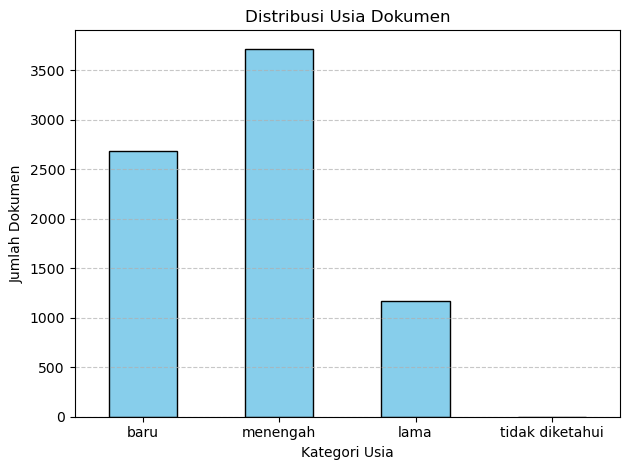

In [11]:
# 5. Usia Dokumen
pu.plot_usia_dokumen(df)

## Pre-Processing Size

In [12]:
# 6. Ukuran File
df = pu.add_size_columns(df)

## Pre-Processing Source

In [13]:
# 7. Sumber File
df = pu.clean_source(df)

## Pre-Processing Path

In [14]:
# 8. Path File
df = pu.standardize_path(df)
df = pu.extract_path_levels(df)
df = pu.add_path_classification(df)

## Pre-Processing Visualization and Refinement FileExt

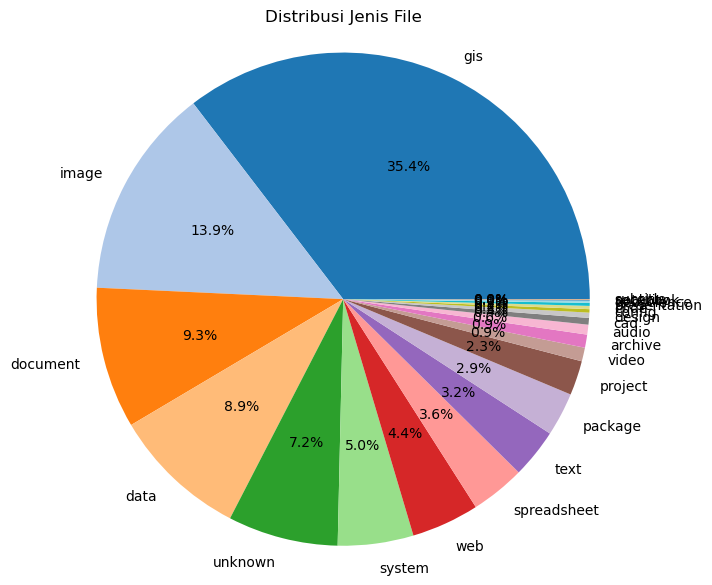

In [15]:
# 9. Analisis & Visualisasi
summary = pu.summarize_filetypes(df)
pu.plot_filetype_distribution(summary)

In [16]:
pd.set_option('display.max_rows', None)  # Menampilkan semua baris

In [20]:
df[df['FileType'] == 'unknown']['FileExt'].value_counts()

FileExt
unknown    547
Name: count, dtype: int64